# Домашняя работа №5.

* Написать модель (с помощью выдвижения гипотез или применяя модель Random Forest) на датасет больных сердечными болезнями.

In [47]:
import numpy as np
from scipy.stats import t
from scipy.stats import norm
import matplotlib.pyplot as plt
from scipy import stats
import pandas as pd
import io
import requests
import seaborn as sns
sns.set_style('darkgrid')
from scipy.stats import pearsonr
import statistics
import ssl
# следующая строчка подключает сертификат для защищенного соединения
ssl._create_default_https_context = ssl._create_unverified_context
%matplotlib inline

In [2]:
url="http://yustiks.ru/dataset/cardio_train.csv"
data=pd.read_csv(url,sep=";")
data.tail()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
69995,99993,19240,2,168,76.0,120,80,1,1,1,0,1,0
69996,99995,22601,1,158,126.0,140,90,2,2,0,0,1,1
69997,99996,19066,2,183,105.0,180,90,3,1,0,1,0,1
69998,99998,22431,1,163,72.0,135,80,1,2,0,0,0,1
69999,99999,20540,1,170,72.0,120,80,2,1,0,0,1,0


Данный датасет разобран в начале лекции 5.

In [22]:
data.iloc[:, 1:-1].columns

Index(['age', 'gender', 'height', 'weight', 'ap_hi', 'ap_lo', 'cholesterol',
       'gluc', 'smoke', 'alco', 'active'],
      dtype='object')

In [25]:
# нормализуем данные
headers = list(data.iloc[:, 1:-1].columns)

from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler(feature_range=(0,1))

np_scaled = min_max_scaler.fit_transform(data.iloc[:, 1:-1])
df_norm = pd.DataFrame(np_scaled)

df_norm.columns = headers
df_norm.tail()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active
69995,0.653659,1.0,0.579487,0.347368,0.016698,0.013550,0.0,0.0,1.0,0.0,1.0
69996,0.913899,0.0,0.528205,0.610526,0.017934,0.014453,0.5,0.5,0.0,0.0,1.0
69997,0.640186,1.0,0.656410,0.500000,0.020408,0.014453,1.0,0.0,0.0,1.0,0.0
69998,0.900736,0.0,0.553846,0.326316,0.017625,0.013550,0.0,0.5,0.0,0.0,0.0
69999,0.754317,0.0,0.589744,0.326316,0.016698,0.013550,0.5,0.0,0.0,0.0,1.0


In [26]:
# поделим данные на тренировочные и тестовые
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(df_norm, data.cardio, test_size = 0.2, random_state = 42)

In [27]:
from sklearn.ensemble import RandomForestClassifier

# создаем модель деревья решений
# выбираем 100 деревьев в качестве параметра
model=RandomForestClassifier(n_estimators=100)

# обучаем модель
model.fit(x_train,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [29]:
from sklearn.metrics import classification_report
model_pred = model.predict(x_test)

print(classification_report(y_test, model_pred))

              precision    recall  f1-score   support

           0       0.71      0.73      0.72      6988
           1       0.72      0.70      0.71      7012

    accuracy                           0.71     14000
   macro avg       0.71      0.71      0.71     14000
weighted avg       0.71      0.71      0.71     14000



Модель Random Forest при обучении дает такой метод как feature importance, используя его, можно оценить, какой параметр **максимально** влияет на болезнь.

No handles with labels found to put in legend.


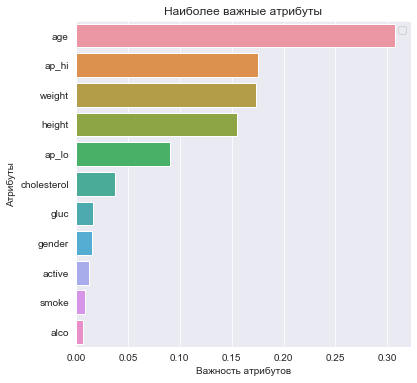

In [31]:
feature_imp = pd.Series(model.feature_importances_,index=headers).sort_values(ascending=False)

f, ax = plt.subplots(figsize=(6, 6))
sns.barplot(x=feature_imp, y=feature_imp.index)

plt.xlabel('Важность атрибутов')
plt.ylabel('Атрибуты')
plt.title("Наиболее важные атрибуты")
plt.legend()
plt.show()

* Сделать вывод о том, какой атрибут оказывает значительное влияение на наличие или отсутствие болезни.

In [32]:
# значительное влияние на наличие или отсутствие болезни оказывает возраст

Основная задача: определить, что влияет на сердечную болезнь больше всего. Например, выдвигая гипотезу о том, что тот кто курит, болеет чаще, мы сравниваем курящих пациентов с некурящими, и определяя насколько статистически значимы выборки, делаем вывод, что одна выборка статистически отличима от другой (или неотличима). Выдвигаем гипотезу на самый важный атрибут, полученный из feature_importance (Random_Forest). И оцениваем гипотезу. И делаем вывод.

In [33]:
# проверим корреляцию между возрастом и наличием болезни
from scipy.stats import pearsonr
pearsonr(data.age, data.cardio)

(0.2381592274423065, 0.0)

In [41]:
# выдвигаем гипотезу о том, что люди старше 50 лет (18250 дней) болеют одинаково часто, что и люди моложе 50 лет
# воспользуемся t-test

# проверим на нормальность
from scipy.stats import shapiro
shapiro(data.age)
# данные распределены не нормально, но для простоты будем считать,что распределение близко к нормальному

(0.9660672545433044, 0.0)

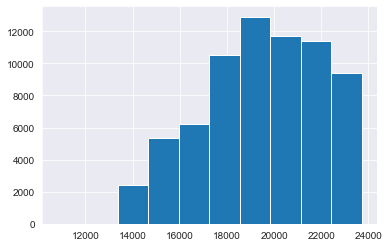

In [42]:
plt.hist(data.age)
plt.show()

In [54]:
# формируем выборки
age_young = data[data['age'] < 18250]['cardio']
age_old = data[data['age'] >= 18250]['cardio']

In [55]:
# проверяем дисперсии
statistics.variance(age_young), statistics.variance(age_old)

(0.2326052089209091, 0.2466762632138512)

In [56]:
stats.ttest_ind(age_young, age_old)

Ttest_indResult(statistic=-46.95521822745856, pvalue=0.0)

In [57]:
# значение p-value < 0,05 говорит о том, что мы отклоняем нулевую гипотезу и полагаем,
# что люди старше 50 лет болеют чаще (положительная корреляция), чем люди моложе 50 лет